# EC444 - Synthesis and Optimization of Digital Circuits
### BDD Assignment/project: Adithya Jayan - 181EC102 | Karthik Rao - 181EC120

#### Installing and importing required Libraries

In [9]:
!pip install networkx #Install required plotting library 

import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

ERROR: Invalid requirement: '#Install'


#### Defining a class to process and hold variables related to the boolean function

In [5]:
class Parse_String:
    """
    A Class to represent a boolean function. It stores the expression in an easy to use format and also
    contains the needed functions to operate on the expression.
    
    """
    
    
    def __init__(self,expression, verbose = True): 
        """
        Initializes an object and stores the expression in the required format for easy use.
        
        """
        
        try:
            terms = expression.replace(" ","").split("+")

            for i in range(len(terms)):
                terms[i] = self.breakdown(terms[i])

            self.expression = terms
            if(verbose):
                print("Successfully parsed [{}].".format(self.display()))
            
        except:
            print("Given expression is invalid")
            

    def calculate_cofactor(self, term, show_steps=False, verbose = True):
        """
        Calculates the cofactors of the expression by calling calculate_single_cofactor reccursively.
        
        """
        
        cofactor = self.expression
        for i in self.breakdown(term): #Calculate cofactors one variable at a time
            cofactor = self.calculate_single_cofactor(i,cofactor) 
            
            if(show_steps): #Option to show intermediate steps
                print("cofactor after", i , "is" , [self.display(cofactor)])
                
            if(cofactor == [['1']]): #If any SoP term = 1, remaining terms need not be calculated
                break
        
        if verbose:
            print("\nCofactor of [{}] with respect to [{}] is:\n [{}]".format(self.display(self.expression),self.display(term),self.display(cofactor)))
        
        return(self.display(cofactor))
        
    def calculate_single_cofactor(self,term,expression = None):
        """
        Calculates the cofactor of the given expression with respect to the given term.
        
        """
        
        if (expression == None):
            expression = self.expression
            
        cofactor = []
        for word in expression:
            if(term in word): #Remove variable from term if variable is present (Since A*1 = A)
                word = [ i for i in word if i!=term]

            if(word == []): #If all terms are removed(i.e., all terms are 1), total value is 1
                cofactor = [['1']]
                break
            
            if(self.invert(term) not in word): #If inverse is present in term, then term value is 0 and hence skipped
                cofactor = cofactor + [word]
            
        if(len(cofactor)==0): #If all terms are skipped(all terms have value 0), total value is 0
            cofactor = [['0']]
                
        return(cofactor)
        
        
    def breakdown(self,term):
        """
        Breaks down a product term into a list of variables.
        Ex: AB'C is broken down into [A,B',C] .
        
        """
        out = []
        for val in term:
            if(val=="'"):
                if("'" in out[-1]):
                    out[-1] = out[-1][:-1]
                else:
                    out[-1] = out[-1] + "'"
            else:
                out = out + [val]
        return(out)
    
    def display(self,expression = None):
        """
        Converts the expression from a list of variables into an easy-to-read SoP string format.
        Ex: [[A,B',C],[D]] is converted to AB'C + D.
        
        """
        if (expression == None): #Display orginal expression by default
            expression = self.expression
        
        if (type(expression[0]) is not list): #In case only one product term exists in SoP
            expression = [expression]
        
        out = ' + '.join([''.join(term) for term in expression])
        return(out)
    
    def invert(self,Var):
        """
        Inverts the value of a single variable.
        EX: A is converted to A' and vice versa.
        
        """
        if(Var[-1]=="'"):  
            Var=Var.replace("'","")
        else:
            Var = Var+"'"
        return(Var)

    def unique_variables(self,expression = None):
        """
        Returns a list of unique variables used in the boolean expression.
        
        """
        if (expression == None): #Read the orginal expression by default
            expression = self.expression
            
        output = list(set(self.display(expression).replace("+","").replace(" ","").replace("'","")))
        return(output)          

####  Q1.Find the cofactors of the function with respect to any given variable or a set of variables (a, ab ab’ etc)  and display the results

In [6]:
##Inputs
SoP = "AC + A'BC' + AB' + DAB' + AEFG' + G + EC"  #Define Input Boolean Expression
cofactor_term = "C'AF" #Variable with respect to calculate cofactor 

##Execution
Boolean_expression = Parse_String(SoP) #Create Boolean expression variable
Boolean_expression.calculate_cofactor( cofactor_term, show_steps = False); #Calculate and display cofactor

Successfully parsed [AC + A'BC' + AB' + DAB' + AEFG' + G + EC].

Cofactor of [AC + A'BC' + AB' + DAB' + AEFG' + G + EC] with respect to [C'AF] is:
 [B' + DB' + EG' + G]


#### Defining functions and classes required for calculating and plotting ROBDD from boolean expression

In [31]:
class bdd_node:
    """
    A class for representing nodes of the ROBDD
    
    """
    n_nodes = 0; #Count for total number of nodes created in the tree
    
    def __init__(self,name = None,expression = None,zero_child=None,one_child=None,parent=None,Node_number=None,child_type=None):
        """
        Defines important values during creation of a new node
        
        """
        self.name = name #Name of the node - Variable with respect to which decision is taken by the tree
        self.zero_child = zero_child #The Node_number of the child node that is connected to the zero edge of this node
        self.one_child = one_child #The Node_number of the child node that is coonnected to the one edge of this node
        self.parent = parent #The Node_number of the parent node of this node
        self.expression = expression #The expression evaluated by this node
        bdd_node.n_nodes = bdd_node.n_nodes + 1 #Total number of nodes created (For debugging)
        self.Node_number = Node_number #The position of the this node in the lost of all nodes
        self.child_type = child_type #Whether this node is a zero-child of its parent or one-child of its parent
   
    def __del__(self):
        """
        Reduces total number of nodes when deleting a node
        
        """
        bdd_node.n_nodes = bdd_node.n_nodes - 1
        
    def status(self):
        """
        Displays all node parameters.(All the variable values)
        
        """
        print("-------------Status--------------")
        print("Name = ",self.name)
        print("zero_child",self.zero_child)
        print("one_child",self.one_child)
        print("parent",self.parent)
        print("expression",self.expression)
        print("n_nodes",bdd_node.n_nodes)
        print("Node_number",self.Node_number)
        print("child_type",self.child_type)
        print("----------------------------------")
        
def Generate_ROBDD(expression,variables=None):
    """
    Calculates and plots a Reduced ordered binary decision diagram of the given boolean expression.
    
    """
    
    parsed_expression = Parse_String(expression,verbose = 0)
    
    if (variables == None): #Use provided variable order if available, else generates an order
        variables = parsed_expression.unique_variables()
    
    #Generate a list of nodes with all required parameters based on given expression
    
    Nodes = [bdd_node(variables[0],expression=expression,Node_number=0)] #Main node [With the orginal expression]
    #For each node in the list of nodes, we add its children to the list as well
    for pos,node in enumerate(Nodes):
        parent = Parse_String(node.expression,verbose=False)
        
        if((node.expression != "0") and (node.expression != "1")):
            
            #Define the name of the node (Defined as 0 or 1 for leaf nodes)
            child1 = parent.calculate_cofactor(node.name+"'",verbose=False)             
            if((child1== '0') or (child1== '1')):
                node_name_1 = child1
            else:
                node_name_1 = variables[variables.index(node.name)+1]
            
            child2 = parent.calculate_cofactor(node.name,verbose=False) 
            if((child2== '0') or (child2== '1')):
                node_name_2 = child2
            else:
                node_name_2 = variables[variables.index(node.name)+1]

            #Adding the children nodes to the list of nodes
            Nodes.append(bdd_node(node_name_1,child1,parent=node.Node_number,Node_number = len(Nodes),child_type = 0))
            Nodes.append(bdd_node(node_name_2,child2,parent=node.Node_number,Node_number = len(Nodes) ,child_type = 1))
            
            Nodes[pos].zero_child = len(Nodes)-2
            Nodes[pos].one_child = len(Nodes)-1
    
    #Reduction of generated graph node-list
    Optimised_graph = []
    for node in Nodes[::-1]:
        
    #Rule2:Merge equivalent leaves and Rule1: Merge isomorphic nodes
        check = [((ele.name==node.name) and (ele.zero_child == node.zero_child) and (ele.one_child == node.one_child)) for ele in Optimised_graph]
        if any(check):
            #print("*****************************Node already exists:*************************")
            if(node.parent!=None):
                if(node.child_type==0):
                    Nodes[node.parent].zero_child = Optimised_graph[check.index(True)].Node_number
                    #print("Modified zero_child of {} to {}".format("["+Nodes[node.parent].expression+"]:"+Nodes[node.parent].name,Optimised_graph[check.index(True)].Node_number))
                    #Nodes[node.parent].status()
                else:
                    Nodes[node.parent].one_child = Optimised_graph[check.index(True)].Node_number
                    #print("Modified one_child of {} to {}".format("["+Nodes[node.parent].expression+"]:"+Nodes[node.parent].name,Optimised_graph[check.index(True)].Node_number))
                    #Nodes[node.parent].status()
                    

        else:
            #print("*********************************Adding new node*******************************")
            
            #Rule3:Eliminate redundant tests(If both 0 and 1 lead to the same child-node)
            if((node.one_child == node.zero_child) and  (node.parent!=None) and (node.expression not in ['0','1'])):
                Optimised_graph[node.one_child].parent = node.parent
                if(node.child_type):
                    Nodes[node.parent].one_child = node.one_child
                else:
                    Nodes[node.parent].zero_child = node.one_child
                #print("killed redundant-node",node.expression,":",node.name)
                
            else:    
                
                Optimised_graph.append(node)
                Optimised_graph[-1].Node_number = len(Optimised_graph)-1
                if(node.parent!=None):
                    #print("Valid Parent for new node")
                    if(Optimised_graph[-1].child_type==0):
                        Nodes[node.parent].zero_child= Optimised_graph[-1].Node_number
                        #print("Modified zero_child of {} to {}".format("["+Nodes[node.parent].expression+"]:"+Nodes[node.parent].name,Optimised_graph[-1].Node_number))
                        #Nodes[node.parent].status()
                    else:
                        Nodes[node.parent].one_child= Optimised_graph[-1].Node_number
                        #print("Modified one_child of {} to {}".format("["+Nodes[node.parent].expression+"]:"+Nodes[node.parent].name,Optimised_graph[-1].Node_number))
                        #Nodes[node.parent].status()
                    
            #print("Added new node at position {}:".format(Optimised_graph[-1].Node_number),Optimised_graph[-1].expression)
            #node.status()
            
        #print("Current list of nodes is:{}\n".format([i.expression for i in Optimised_graph]))
        
#     print("**********************************Summary*****************************************")
#     for i in Optimised_graph:
#         i.status()
    
    print("******************  CONSTRUCTING GRAPH **********************")
    plt.figure(figsize=(16,16))

    G = nx.DiGraph()
    plt.margins(x=0.2)

    for position,node in enumerate(Optimised_graph):
        G.add_node("{}\n({})".format(node.name,node.expression))            
        if((node.expression != '0') and (node.expression != '1')):
            if(node.zero_child == node.one_child):
                G.add_edge("{}\n({})".format(node.name,node.expression),"{}\n({})".format(Optimised_graph[node.zero_child].name,Optimised_graph[node.zero_child].expression), Input=("0 , 1"),color='b')
            else:
                G.add_edge("{}\n({})".format(node.name,node.expression),"{}\n({})".format(Optimised_graph[node.zero_child].name,Optimised_graph[node.zero_child].expression), Input=0,color='r')
                G.add_edge("{}\n({})".format(node.name,node.expression),"{}\n({})".format(Optimised_graph[node.one_child].name,Optimised_graph[node.one_child].expression), Input=1,color='g')
            
    edge_labels = dict([((n1, n2), d['Input']) for n1, n2, d in G.edges(data=True)]) 
    pos = graphviz_layout(G, prog="dot")
    colors = [G[u][v]['color'] for u,v in G.edges()]
    nx.draw(G, with_labels=True,pos=pos,style = "solid",connectionstyle="arc3,rad=0.1",node_size = 3000,node_color="none",edge_color=colors,width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.7,font_color='black', font_size=8, font_weight='bold')
    
    plt.show()

#### Q2.For a given variable ordering, find and display the ROBDD of the function.

******************  CONSTRUCTING GRAPH **********************


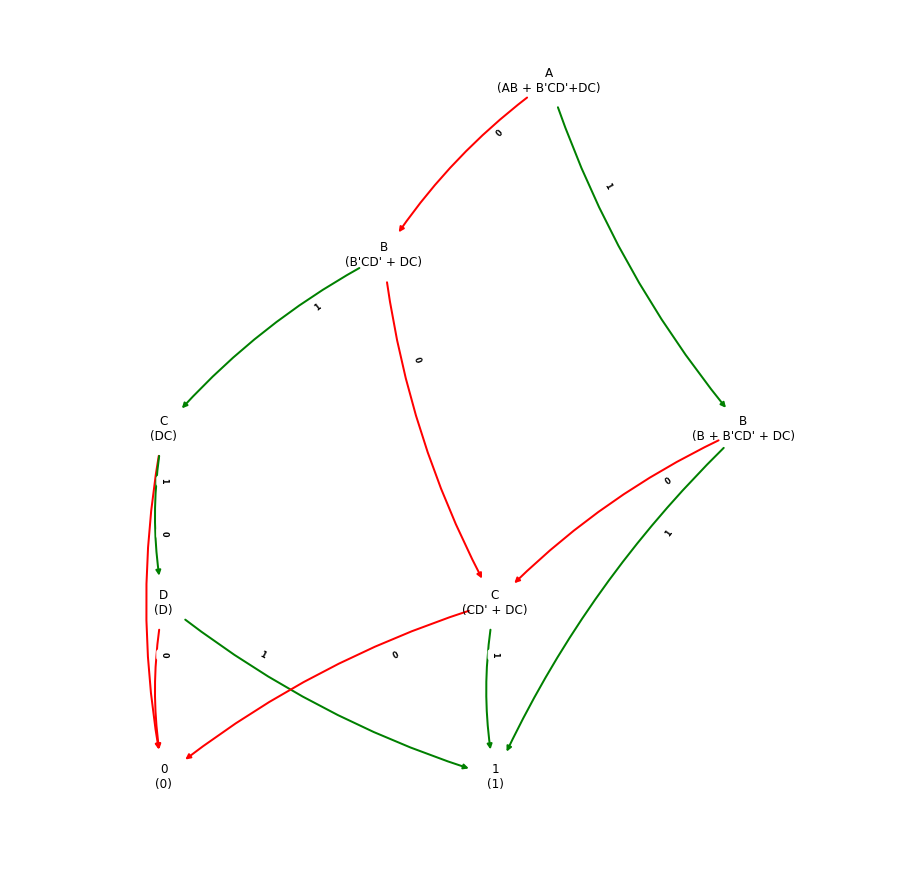

In [32]:
Boolean_expression = "AB + B'CD'+DC"
Variable_ordering = "ABCD"


Generate_ROBDD(Boolean_expression,Variable_ordering)

******************  CONSTRUCTING GRAPH **********************


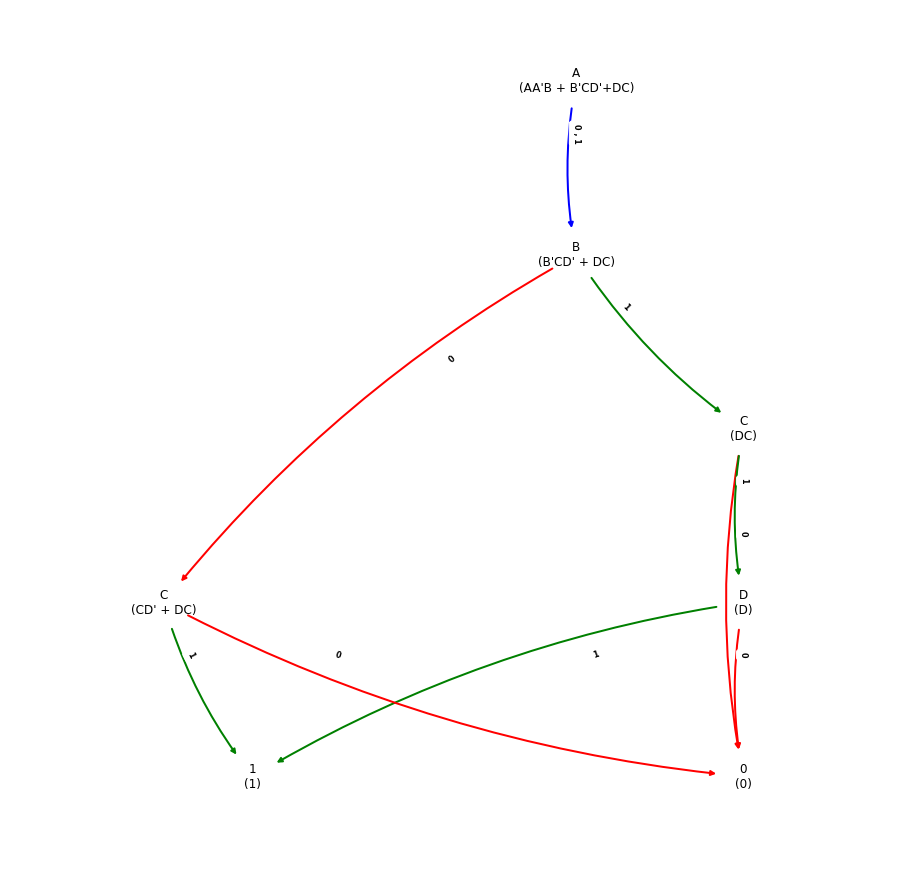

In [33]:
Generate_ROBDD("AA'B + B'CD'+DC","ABCD")